In [1]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt

In [2]:
cluster='Ruprecht_147'
objectid='219652181'
t_start,t_stop,id_start,id_stop,comment=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_my_flares.txt',delimiter=',',unpack=True,dtype=[('t_start', np.float), ('t_stop', np.float), ('id_start', np.int), ('id_stop', np.int), ('comment', 'S32')])
time,flux_gap,error,flux_model=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'.txt',delimiter=',',unpack=True)
istart, istop=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_flares.txt',delimiter=',',unpack=True,dtype=np.dtype(np.int16))


In [3]:
def ED(start,stop,time,flux_model,flux_gap):
    time=time[start:stop+1]
    model=flux_model[start:stop+1]
    flux=flux_gap[start:stop+1]
    residual=np.subtract(flux,model)
    flare=trapz(residual,time)
    quiet=trapz(model,time)
    ed=flare/quiet
    return ed


In [4]:
myED=[]

for start, stop in zip(id_start,id_stop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    myED.append(ed)

    
AppaED=[]

for start, stop in zip(istart,istop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    AppaED.append(ed)



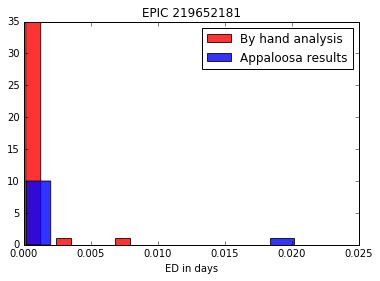

In [5]:

plt.figure()
plt.title('EPIC '+objectid)
plt.hist(myED,len(myED)//5,alpha=0.8,color='red',label='By hand analysis')
plt.hist(AppaED,len(AppaED)//1,alpha=0.8,label='Appaloosa results')
plt.legend()
plt.xlabel('ED in days')
plt.show()
#plt.savefig('results/'+objectid+'_byhand_vs_Appaloosa.png')

- ~~retrieve colors~~
- ~~retrieve distances for cluster~~
- ~~from colors estimate spectral class~~
- from spectral class use spectrum from Sarah's SpecPhot
- from spectral class use radius from XXX
- use Kepler filter curve to calculate quiescent flux:
- L_∗ = πR^2 ∗int( dλ R_Kepler(λ)* B_SpecPhot(λ))
- Finally: ED*L_*=Kepler energy

In [6]:
params=open('share/cross_match/union/'+cluster+'_parameter.txt')
param_dict=dict()
basics=params.readline()
#print(basics)
basics=[u for u in basics[1:-2].split(', ')]
for line in params:
    s=np.core.defchararray.split(line, sep=",").tolist()
    col=s[3:]
    col=[float(item) for item in col]
    try:
        param_dict[int(s[0])]=[int(s[1]),s[2],col]
    except ValueError:
        param_dict[int(s[0])]=[s[1],s[2],col]
#print(param_dict)

In [248]:
#if band value == -999.0 no magnitude is given

#read in table for spectral class: read in as list [class,lum_class,u-g,g-r,r-i,i-z,z-J,J-H,H-k,Jmag_abs]
#LATER: Add z-y from mamajek or so...
import numpy as np
spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs=np.loadtxt('share/cross_match/union/spectralclasses_padded.csv',skiprows=49,delimiter=',',unpack=True,dtype=[('spec_class','S4'),('lum_class','U3'),('u-g',np.float),('g-r',np.float),('r-i',np.float),('i-z',np.float),('z-J',np.float),('J-H',np.float),('H-K',np.float),('Jmag_abs',np.float)])
spec_class=[x.strip(' ') for x in spec_class]
lum_class=[x.strip(' ') for x in lum_class]
lum_class_I=[i for i,x in enumerate(lum_class) if x=='I']
lum_class_III=[i for i,x in enumerate(lum_class) if x=='III']
lum_class_V=[i for i,x in enumerate(lum_class) if x=='V']

#spec_class_I=[x for i,x in enumerate(spec_class) if i in lum_class_I]
lookup_spec={'Jmag_abs':Jmag_abs,'V':lum_class_V,'III':lum_class_III,'I':lum_class_I,'class':spec_class,'ug':ug,'gr':gr,'ri':ri,'iz':iz,'zJ':zJ,'jh':JH,'hk':HK}

In [249]:
#calculate distance modulus for cluster
DM = lambda x: 5.*np.log10(float(x))-5. #I used a lambda function!
dm=DM(basics[3])
print(dm)
global dm

7.3856062736


In [256]:

def find_spec_class(lookup_spec,color, index,l='V'):
    try:
        spec_class=lookup_spec['class']
        lum_class=lookup_spec[l]

        color_list=lookup_spec[index]
        i_lam=min(color_list, key=lambda x:abs(x-color))
        idx=search(color_list[lum_class],color)
        if len(idx)!=0:
            spec_classes=[spec_class[j] for j in idx]

        else:
            spec_classes='color too high or low to be assigned to spectral class in this luminosity class'
        return idx,[spec_classes,l]
    except KeyError:
        idx=[]
        return idx,'no entries for this color index'
    
def search(l1, val):
    results=[]
    l1=list(l1)
    l2=l1[1:]+[-l1[-2]+2.*l1[-1]]
    #print(l1,l2)
    for i,j in zip(l1,l2):
        if i<val<j:
            if (val-i > val-j): 
                results.append(l1.index(i))
            else:
                if (j==l2[-1]):
                    results.append(l1.index(i))
                else:
                    results.append(l1.index(j))
    #print(results)

    return results
            

In [281]:
import random
def insert_spec_class(c,lookup_spec,c1,c2,index,l='V'):
    if c1!=-999.0 and c2!=-999.0:
        idx,all_spectral_classes=find_spec_class(lookup_spec,c1-c2,index,l)
        c[index]=[c1-c2,all_spectral_classes]
    else:
        idx=[]
    return idx

def insert_lum_class(c,lookup_spec,J,index,l='V'):
    if J!=-999.0:
        J-=dm
        idx, all_spectral_classes=find_spec_class(lookup_spec,J,'Jmag_abs',l)
        c[index]=[J,all_spectral_classes]
    else:
        idx=[]
    return idx

def optimize_spec_class(obj_handle,colors,lookup_spec,c_idx='jhkJ',debug=False):
    color_indices={'jhkJ':{'jh':colors[:2],'hk':colors[1:3],'J':colors[3]},'grizyJ':{'gr':colors[:2],'ri':colors[1:3],'iz':colors[2:4],'zy':colors[3:5]}}#,'J':colors[5]
    luminosity_classes={'I':0.01,'III':0.,'V':-0.01}
    indices=color_indices[c_idx]
    lum_opt=dict()
    minspread=10000
    best_lum_class='V'
    best_spec_class='None'
    for lum_class, weight in luminosity_classes.items():
        print('-------------')
        print(lum_class)
       
        spr=[]
        color_results={}
        for key,value in indices.items():
            
            if key=='J':
                idx=insert_lum_class(obj_handle,lookup_spec,value,key,l=lum_class)
            else:
                c1,c2=value
                idx=insert_spec_class(obj_handle,lookup_spec,c1,c2,key,l=lum_class)
 
            color_results[key]=idx
        print(color_results)
        opt=dict()
        dist=0
        for i in range(100):
            key=random.choice(list(color_results.keys()))
            if color_results[key]!=[]: 
                print(key)
                break
        value=color_results[key]
        rest_results=dict(color_results)
        del rest_results[key]
        mindist=1000
        for index in value:
            if debug==True:
                opt[key]=index
            else:
                opt[key]=lookup_spec['class'][index]
            spr.append(index)
            d=0
            for key2, value2 in rest_results.items():
                delta=[abs(x-index) for x in value2]
                #print(delta)
                if delta!=[]:
                    dadd=min(delta)
                    d+=dadd
                    minind=value2[delta.index(dadd)]
                    if debug==True:
                        opt[key2]=minind
                    else:
                        opt[key2]=lookup_spec['class'][minind]
                    spr.append(minind)
            #average over number of color entries available
            d=d/len(color_results)
            print(d)
            if d<mindist:
                mindist=d
                print(opt)
            else:
                print('Better solution found, clear:')
                print(opt)
                opt.clear()
        
        spread=np.std(np.array(spr))
        mean=np.mean(np.array(spr))

        if spread+weight<minspread:
            minspread=spread
            best_lum_class=lum_class
            best_spec_class=lookup_spec['class'][int(np.rint(mean))]
        
        lum_opt[lum_class]=[spread,opt]
        
    print('-------------------')
    print('Best results for spectral class and luminosity class: L={} and spec={}.'.format(best_lum_class,best_spec_class))
    print()
        
    return best_lum_class,best_spec_class,lum_opt



In [282]:
ID,c_idx,colors, results=param_dict[219630699]
optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=False)

-------------
I
{'ri': [26], 'iz': [31], 'zy': [], 'gr': []}
ri
1.25
{'iz': 'M3', 'ri': 'K7'}
-------------
III
{'ri': [17], 'iz': [22], 'zy': [], 'gr': []}
ri
1.25
{'iz': 'K2', 'ri': 'G0'}
-------------
V
{'ri': [22], 'iz': [26], 'zy': [], 'gr': []}
iz
1.0
{'iz': 'K7', 'ri': 'K2'}
-------------------
Best results for spectral class and luminosity class: L=V and spec=K4.



('V',
 'K4',
 {'I': [2.5, {'iz': 'M3', 'ri': 'K7'}],
  'III': [2.5, {'iz': 'K2', 'ri': 'G0'}],
  'V': [2.0, {'iz': 'K7', 'ri': 'K2'}]})

In [283]:
for key,value in param_dict.items():
    print(key)
    ID,c_idx,colors, results=value
    optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=False)

219716873
-------------
I
{'ri': [], 'iz': [], 'zy': [], 'gr': []}
-------------
III
{'ri': [], 'iz': [28], 'zy': [], 'gr': []}
iz
0.0
{'iz': 'M1'}
-------------
V
{'ri': [], 'iz': [32], 'zy': [], 'gr': []}
iz
0.0
{'iz': 'M4'}
-------------------
Best results for spectral class and luminosity class: L=V and spec=M4.

219810798
-------------
I
{'ri': [30], 'iz': [31], 'zy': [], 'gr': []}
ri
0.25
{'iz': 'M3', 'ri': 'M2.5'}
-------------
III
{'ri': [21], 'iz': [22], 'zy': [], 'gr': []}
iz
0.25
{'iz': 'K2', 'ri': 'K0'}
-------------
V
{'ri': [25], 'iz': [26], 'zy': [], 'gr': []}
iz
0.25
{'iz': 'K7', 'ri': 'K5'}
-------------------
Best results for spectral class and luminosity class: L=V and spec=K7.

219626912
-------------
I
{'ri': [], 'iz': [], 'zy': [], 'gr': []}
-------------
III
{'ri': [], 'iz': [], 'zy': [], 'gr': []}
-------------
V
{'ri': [], 'iz': [], 'zy': [], 'gr': []}
-------------------
Best results for spectral class and luminosity class: L=V and spec=None.

219712041
------

In [64]:
#deprecated analysis version, maybe useful for debugging later...
for key,value in param_dict.items():
    
    if len(value)==4:
        c=value[3]
    else:
        value.append(dict())
        c=value[3]
    if value[1]=='jhkJ':
        j,h,k,J=value[2]
        insert_spec_class(c,lookup_spec,j,h,'jh')
        insert_spec_class(c,lookup_spec,h,k,'hk')
        insert_lum_class(c,lookup_spec,J,'J')
        
    elif value[1]=='grizyJ':
        g,r,i,z,y,J=value[2]
        insert_spec_class(c,lookup_spec,g,r,'gr')
        insert_spec_class(c,lookup_spec,r,i,'ri')
        insert_spec_class(c,lookup_spec,i,z,'iz')
        insert_spec_class(c,lookup_spec,z,y,'zy')
        insert_lum_class(c,lookup_spec,J,'J')

    print(key,c)
#check with spectral class table. find value in ordered list
#check distance with luminosity class using absolute Jmag_abs and J from param_dict
#add color_index, spec_class to obj#bokeh barplot spectral classes

[[], [], []]